# Grad-CAM visualisation
This notebook is used to provide visual explanation for CNN predictions, calculating heatmap of regions, that are most important for specific final prediction.

I implemented two methods, Grad-CAM and guided Grad-CAM. Guided Grad-CAM should provide better prediction explanation as it uses guided backpropagation to focus only on gradients, that contribute positively to the final prediction.

Both methods are implemented inside ***utils.py*** with detailed descriptions.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

2022-05-09 01:08:31.897196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 01:08:31.897265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from utils import *
from image_preprocessing import *

2022-05-09 01:08:36.525509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matus/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-09 01:08:36.525541: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 01:08:36.525568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matus-Latitude-E7440): /proc/driver/nvidia/version does not exist
2022-05-09 01:08:36.525832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Constants

In [3]:
# FILEPATHS
DATASET_PATH = '../datasets/tvt_detailed_paths.csv' # Path to csv file with dataset information (train-valid-test split)
DATASET_DIR = '../datasets/original/' # Specify directory with dataset you want to use

# GENERATOR AND DATAFRAME FLOW
TARGET_SIZE = (224, 224) # Image target size, must match the model input
BATCH_SIZE = 1 # We want to visualize one image at a time
PREP_FUNC = clahe_10_rescale # Function passed into ImageDataGenerator, should match the model training preprocessing

# MODEL
BASE_NAME = 'ResNet50' # Name of Keras applications architecture to be used as a base
WEIGHTS = '../models/ResNet50_clahe_10_all_best.h5' # Weights to be loaded in chosen model
INPUT_SHAPE = (224, 224, 3) # CNN model input shape

# Build model and load weights obtained from training

The choice of model and weights is not limited, Grad-CAM methods are universal

In [4]:
model = build_model(base_name=BASE_NAME,
                    weights=WEIGHTS,
                    shape=INPUT_SHAPE,
                    name='trained_model',
                    pooling='avg')

Loaded weights from ../models/ResNet50_clahe_10_all_best.h5


# Manual image preparation
You can visualize GradCAM for specific images using this function. The image should be preprocessed the same way it was preprocessed during the training of selected model.

In [8]:
def prepare_img(prep_func, dataframe=None, filepath=None):
    """
    Function for manually preparing image for GradCAM. The image is loaded using PIL library, to match the loading
    and resizing done by Keras and TensorFlow. The image is resized to match the model input, then the preprocessing
    function is applied.
    
    Parameters
    ----------
    prep_func: function
        Function that accepts an image array as a parameter and returns the preprocessed image
    dataframe: pd.Dataframe or None
        Source for random image filepath if no specific filepath is provided
    filepath: str or None
        Filepath for loading the image, if none is provided, random path from notebook-defined dataframe is selected
    
    Returns
    -------
    Preprocessed image array
    """
    if filepath is None:
        filepath = DATASET_DIR + dataframe.sample(n=1).filepath.item()
    print('Image filepath:', filepath)
    
    # Load image and prepare it to match the models input
    pil_img = Image.open(filepath)
    pil_img = pil_img.convert('RGB')
    pil_img = pil_img.resize(TARGET_SIZE, Image.NEAREST)
    # Return preprocessed image
    return PREP_FUNC(np.asarray(pil_img))

# Create generator and dataframe flow

In [6]:
# Load desired portion of the dataset
df = get_dataframe('ALL', 'test', DATASET_PATH)
# We mostly want to see how our model detects positive images
df_positive = df.loc[df['label'] == 'positive']

# Create generator without augmentation
gen = ImageDataGenerator(preprocessing_function=PREP_FUNC)

# Create dataframe flow
flow = gen.flow_from_dataframe(dataframe=df_positive,
                               directory=DATASET_DIR,
                               x_col='filepath',
                               y_col='label',
                               class_mode='raw',
                               target_size=TARGET_SIZE,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               seed=27)

Found 241 validated image filenames.


# Run Grad-CAM

Image filepath: ../datasets/original/MURA-v1.1/test/XR_FOREARM/patient09223/study1_positive/image2.png
Prediction output: tf.Tensor([0.9862453], shape=(1,), dtype=float32)


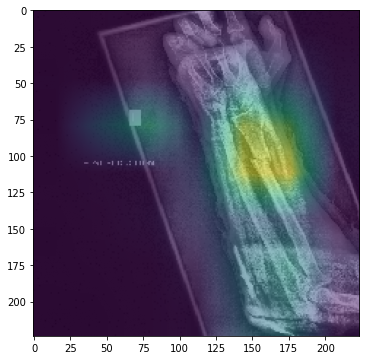

In [29]:
# Choose which method for obtaining the image you want to use
# image = next(flow)[0].squeeze() # Get one image from dataframe flow
image = prepare_img(prep_func=PREP_FUNC, dataframe=df_positive, filepath=None) # Get one manually prepared image


# Select which Grad-CAM method you wish to use, it returns heatmap that will be plotted on top of predicted image
# heatmap = guided_grad_cam(image, resNet)
heatmap = guided_grad_cam(image, model)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.imshow(heatmap, alpha=0.5)
plt.show()